In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[reg_cols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[reg_cols].copy().drop_duplicates()
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(old_train_data,old_test_data,train_to_date):
    new_train = pd.concat([old_train_data,old_test_data[old_test_data.index<=train_to_date]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False)
    new_test = old_test_data[~old_test_data.index.isin(new_train['calculation_date'])].copy().reset_index(drop=False)
    arrs = trainer.get_train_test_arrays(new_train, new_test)
    train_X = arrs['train_X']
    train_y = arrs['train_y']
    test_X = arrs['test_X']
    test_y = arrs['test_y']
    preprocessor = trainer.preprocess()
    retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
    train_data, test_data, errors = trainer.test_prediction_accuracy(retrained_model,new_test,new_train)
    new_test_data = test_data.set_index('calculation_date')
    new_train_data = train_data.set_index('calculation_date')
    print()
    plot_errors(plotcols,new_test_data,new_train_data)
    return new_train_data, new_test_data


"""
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

part_disp_X = train_data[model_fit.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, model_fit.feature_names_in_, ax=ax)

part_disp_X = insample[retrained_model.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(retrained_model, part_disp_X, model_fit.feature_names_in_, ax=ax)
"""

# Loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_29 100027150881 bloomberg barrier options
1     2024_10_29 100220915287 bloomberg asian options


# loading data

In [4]:
from convsklearn import asian_trainer, barrier_trainer
model = models[0]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
    
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

0     2024_10_29 100027150881 bloomberg barrier options insample.csv
1     2024_10_29 100027150881 bloomberg barrier options outsample.csv
2     2024_10_29 100027150881 bloomberg barrier options.pkl
3     2024_10_29 100027150881 bloomberg barrier options.txt


In [5]:
train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('insample')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('outsample')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
model_fit

spot price 
0        676.03
1        682.43
2        683.09
3        696.44
4        701.13
         ...   
1076    1461.17
1077    1461.21
1078    1461.31
1079    1461.36
1080    1465.27
Name: spot_price, Length: 1081, dtype: float64

strike price 
0        608.42700
1        614.18700
2        614.78100
3        625.32775
4        626.79600
           ...    
9715    1607.28700
9716    1607.33100
9717    1607.44100
9718    1607.49600
9719    1611.79700
Name: strike_price, Length: 9720, dtype: float64

days to maturity 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0      0.017912
1      0.017942
2      0.017970
3      0.017981
4      0.017985
         ...   
992    0.035255
993    0.035276
994    0.035596
995    0.035690
996    0.037735
Name: dividend_rate, Length: 997, dtype: float64

kappa 
0        0.083258
1        0.090921
2        0.098043
3        0.0984

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'barrier']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['barrier_type_name',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(13,
                                                                                       13),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

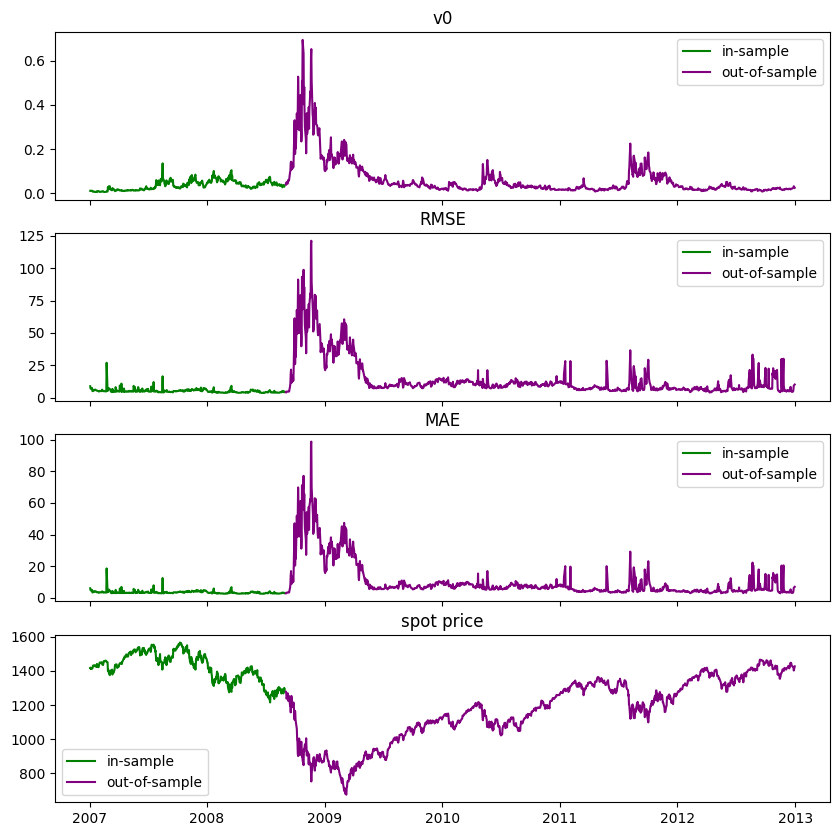

In [6]:
reg_cols = ['kappa','theta','rho','eta','v0','spot_price','RMSE','MAE']
plotcols = ['v0','RMSE', 'MAE','spot_price']
plot_errors(plotcols, test_data, train_data)

# exclusion restriction testing

In [7]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
regression_data = test_data[reg_cols].copy().drop_duplicates()
regression_data

,kappa,theta,rho,eta,v0,spot_price,RMSE,MAE
calculation_date,,,,,,,,
2008-09-02,2.129509,0.060409,-1.000000,0.172868,0.040641,1277.53,4.173915,2.878899
2008-09-03,2.693908,0.058609,-1.000000,0.178095,0.038360,1275.25,4.775320,3.253463
2008-09-04,1.521139,0.062183,-1.000000,0.167885,0.050277,1236.81,4.359355,3.145253
2008-09-05,2.859490,0.059311,-1.000000,0.183520,0.044849,1242.38,4.575543,3.217309
2008-09-08,3.372719,0.055250,-0.735338,0.256952,0.043867,1267.76,4.847501,3.440925
...,...,...,...,...,...,...,...,...
2012-12-24,1.533653,0.045075,-0.758727,0.187296,0.021678,1425.78,4.544801,3.131509
2012-12-26,1.502570,0.045965,-0.631430,0.230292,0.024230,1419.95,4.870463,3.371111
2012-12-27,1.254997,0.049897,-0.471477,0.306944,0.026584,1417.38,6.647420,4.572057


In [8]:
regression_data.dtypes

kappa         float64
theta         float64
rho           float64
eta           float64
v0            float64
spot_price    float64
RMSE          float64
MAE           float64
dtype: object

### unrestricted regression

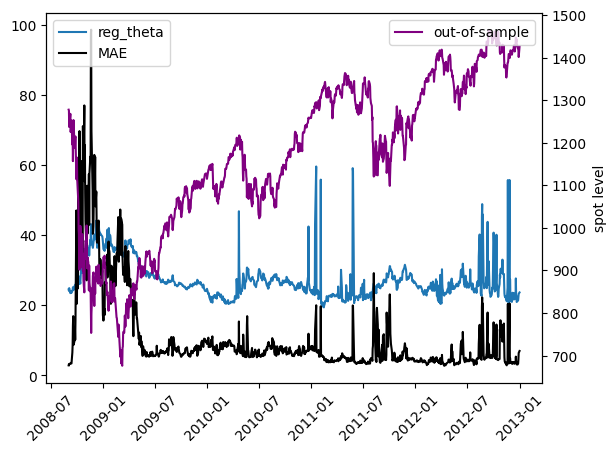

In [9]:
X = pd.DataFrame()
X['reg_s'] = regression_data['spot_price']
# X['reg_v0'] = np.sqrt(regression_data['v0'])*100
X['reg_theta'] = np.sqrt(regression_data['theta'])*100 
# X['reg_kappa'] = regression_data['kappa']
# X['reg_eta'] = regression_data['eta']*100

target_name = 'MAE'
y = regression_data[target_name].loc[X.index]
fit_intercept = False

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
ax2 = ax1.twinx()
for column in X.columns[1:]:
    ax1.plot(X.index, X[column], label=column)
ax1.plot(X.index, y, label=target_name, color="black")
ax2.plot(X.index, X['reg_s'], label='out-of-sample', color="purple")
ax2.set_ylabel("spot level")
ax1.legend(loc='upper left')
ax2.legend(loc="upper right")
plt.show()

In [10]:
Ufit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Uyhat = Ufit.predict(X)
URSS = sum((Uyhat-y)**2)
for i,c in enumerate(Ufit.coef_):
    print(f"{X.columns[i].replace('reg_','')} - b{i}:  {c}")
print(f"intercept: {Ufit.intercept_}")
print(f"R Squared: {Ufit.score(X,y)}")
print(f"\nURSS: {URSS}")

s - b0:  -0.019217215657511208
theta - b1:  1.2123413160205692
intercept: 0.0
R Squared: 0.5171883878817842

URSS: 79005.67563580474


### restricted regression

In [11]:
X = X.iloc[:,1:].copy()
Rfit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Ryhat = Rfit.predict(X)
RRSS = sum((Ryhat-y)**2)
for i,c in enumerate(Rfit.coef_):
    print(f"{X.columns[i].replace('reg_','')} - b{i}:  {c}")
print(f"intercept: {Rfit.intercept_}")
print(f"R Squared: {Rfit.score(X,y)}")
print(f"\nRRSS: {RRSS}")

theta - b0:  0.4318117404267436
intercept: 0.0
R Squared: 0.20283793753060486

RRSS: 130444.9308091735


### F-Test

In [12]:
m = len(Ufit.coef_)-len(Rfit.coef_)
n = len(y)
k = len(Ufit.coef_)
dfn = m
dfd = n-k-1
F = ((RRSS-URSS)/dfn)/(URSS/dfd)
alpha = 0.05
critF = stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
print(f"F: {F}, Critical F: {critF}")

F: 708.3783434321003, Critical F: 3.8500199362676537


In [13]:
for col in X.columns:
    regression_data[col] = X[col]
regression_data['y'] = y
regression_data['Uyhat'] = Uyhat
regression_data['Ryhat'] = Ryhat
regression_data

,kappa,theta,rho,eta,v0,spot_price,RMSE,MAE,reg_theta,y,Uyhat,Ryhat
calculation_date,,,,,,,,,,,,
2008-09-02,2.129509,0.060409,-1.000000,0.172868,0.040641,1277.53,4.173915,2.878899,24.578213,2.878899,5.246613,10.613161
2008-09-03,2.693908,0.058609,-1.000000,0.178095,0.038360,1275.25,4.775320,3.253463,24.209285,3.253463,4.843162,10.453853
2008-09-04,1.521139,0.062183,-1.000000,0.167885,0.050277,1236.81,4.359355,3.145253,24.936516,3.145253,6.463524,10.767880
2008-09-05,2.859490,0.059311,-1.000000,0.183520,0.044849,1242.38,4.575543,3.217309,24.353805,3.217309,5.650040,10.516259
2008-09-08,3.372719,0.055250,-0.735338,0.256952,0.043867,1267.76,4.847501,3.440925,23.505214,3.440925,4.133525,10.149827
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,1.533653,0.045075,-0.758727,0.187296,0.021678,1425.78,4.544801,3.131509,21.230839,3.131509,-1.660498,9.167726
2012-12-26,1.502570,0.045965,-0.631430,0.230292,0.024230,1419.95,4.870463,3.371111,21.439524,3.371111,-1.295465,9.257838
2012-12-27,1.254997,0.049897,-0.471477,0.306944,0.026584,1417.38,6.647420,4.572057,22.337609,4.572057,-0.157291,9.645642


# retraining

In [14]:
train_data

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,...,rho,eta,v0,barrier_price,observed_price,insample_target,insample_prediction,insample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,1416.59,1274.93100,708.2950,60,Down,Out,call,DownOut,0.0,0.018125,...,-1.0,0.098497,0.010662,146.290699,146.283424,146.283424,136.326970,-9.956454,8.871755,6.059018
2007-01-03,1416.59,1381.17525,1430.7559,180,Up,Out,call,UpOut,0.0,0.018125,...,-1.0,0.098497,0.010662,0.119558,0.119801,0.119801,0.208442,0.088641,8.871755,6.059018
2007-01-03,1416.59,1381.17525,1430.7559,90,Up,In,put,UpIn,0.0,0.018125,...,-1.0,0.098497,0.010662,8.640475,8.659863,8.659863,8.228621,-0.431243,8.871755,6.059018
2007-01-03,1416.59,1381.17525,1430.7559,90,Up,In,call,UpIn,0.0,0.018125,...,-1.0,0.098497,0.010662,57.704872,57.710529,57.710529,45.217967,-12.492562,8.871755,6.059018
2007-01-03,1416.59,1381.17525,1430.7559,90,Up,Out,put,UpOut,0.0,0.018125,...,-1.0,0.098497,0.010662,6.788996,6.756677,6.756677,10.455553,3.698877,8.871755,6.059018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08-29,1283.32,1315.40300,1270.4868,720,Down,In,put,DownIn,0.0,0.022617,...,-1.0,0.170760,0.034935,152.616342,152.638631,152.638631,148.716381,-3.922250,4.451899,3.006612
2008-08-29,1283.32,1347.48600,641.6600,60,Down,Out,call,DownOut,0.0,0.022617,...,-1.0,0.170760,0.034935,16.726021,16.728844,16.728844,20.238261,3.509417,4.451899,3.006612
2008-08-29,1283.32,1347.48600,641.6600,60,Down,Out,put,DownOut,0.0,0.022617,...,-1.0,0.170760,0.034935,76.816152,76.813223,76.813223,88.446144,11.632922,4.451899,3.006612


In [15]:
test_data

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,...,rho,eta,v0,barrier_price,observed_price,outofsample_target,outofsample_prediction,outofsample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2008-09-02,1277.53,1213.65350,1916.2950,720,Up,Out,call,UpOut,0.0,0.022701,...,-1.000000,0.172868,0.040641,96.074649,96.119544,96.119544,103.844473,7.724929,4.173915,2.878899
2008-09-02,1277.53,1213.65350,1916.2950,720,Up,Out,put,UpOut,0.0,0.022701,...,-1.000000,0.172868,0.040641,109.137227,109.135338,109.135338,110.357010,1.221672,4.173915,2.878899
2008-09-02,1277.53,1213.65350,1916.2950,720,Up,In,call,UpIn,0.0,0.022701,...,-1.000000,0.172868,0.040641,113.539369,113.541582,113.541582,100.942007,-12.599575,4.173915,2.878899
2008-09-02,1277.53,1213.65350,1916.2950,720,Up,In,put,UpIn,0.0,0.022701,...,-1.000000,0.172868,0.040641,0.329745,0.351869,0.351869,0.223398,-0.128471,4.173915,2.878899
2008-09-02,1277.53,1245.59175,1290.3053,60,Up,Out,call,UpOut,0.0,0.022701,...,-1.000000,0.172868,0.040641,0.125792,0.112584,0.112584,3.426477,3.313893,4.173915,2.878899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31,1425.77,1461.41425,1411.5123,360,Down,In,put,DownIn,0.0,0.022233,...,-0.418973,0.324868,0.024660,101.821788,101.845395,101.845395,121.838526,19.993131,10.190270,6.994961
2012-12-31,1425.77,1461.41425,1411.5123,360,Down,In,call,DownIn,0.0,0.022233,...,-0.418973,0.324868,0.024660,78.065144,78.105834,78.105834,90.284368,12.178534,10.190270,6.994961
2012-12-31,1425.77,1461.41425,1411.5123,360,Down,Out,put,DownOut,0.0,0.022233,...,-0.418973,0.324868,0.024660,0.026454,0.054865,0.054865,0.000000,-0.054865,10.190270,6.994961


In [ ]:
train_to_date = pd.Timestamp(2009,4,1)
train_data, test_data = retrain(train_data,test_data,train_to_date)


training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
